# Importing emissions files

This notebook example shows how to run FaIR with your own emissions scenarios. This feature was introduced in fair v2.2.0.

The data is in the `examples/data/importing-data` directory of the fair repository.

The structure of this example closely follows the `basic-run-example`.

In [1]:
import pandas as pd
from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise

import matplotlib.pyplot as pl

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_4445/485057119.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
f = FAIR()

## Set up the run

In [3]:
f.define_time(2000, 2050, 1)  # annual timestep, running from 2000 to 2050
f.define_scenarios(["renewable", "fossil"])  # define two emissions scenarios
f.define_configs(["one", "two", "three"])  # three climate ensemble members

In this example the `species_configs_properties` are read in from an external file.

`species_configs_properties` contains the list of species that you want to run with, how you want to run them, and the default (though modifiable) parameter values that you give them.

In [4]:
species, properties = read_properties("data/importing-data/species_configs_properties.csv")

In [5]:
species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions']

In [6]:
f.define_species(species, properties)

In [7]:
f.allocate()

## Read in our driving data

First, we'll inspect it using `pandas`.

Note that not every `specie` defined is included here, since some are calculated from other species (CO2, aerosol-radiation and aerosol-cloud forcing).

Remember also that emissions are on `timepoints` - so will be calculated on half years.

The `fill_from_csv` function will do our interpolation for us, so it's fine to provide 10-year data for an annual problem.

In [8]:
pd.read_csv('data/importing-data/demo-emissions.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,CO2 FFI,Gt CO2/yr,30,35,37,28,23,14
1,demo,renewable,World,CO2 AFOLU,Gt CO2/yr,3,4,3,1,-1,-3
2,demo,renewable,World,Sulfur,Mt SO2/yr,100,95,80,65,50,38
3,demo,fossil,World,CO2 FFI,Gt CO2/yr,30,35,37,45,50,55
4,demo,fossil,World,CO2 AFOLU,Gt CO2/yr,3,4,3,1,-1,-3
5,demo,fossil,World,Sulfur,Mt SO2/yr,100,95,80,70,60,50


In [9]:
pd.read_csv('data/importing-data/demo-concentration.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,CH4,ppb,1600,1700,1900,1700,1600,1500
1,demo,renewable,World,N2O,ppb,315,325,335,344,353,361
2,demo,fossil,World,CH4,ppb,1600,1700,1900,2100,2300,2500
3,demo,fossil,World,N2O,ppb,315,325,335,345,355,365


In [10]:
pd.read_csv('data/importing-data/demo-forcing.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,Volcanic,W/m2,-0.2,-0.2,-0.1,0,0,0
1,demo,fossil,World,Volcanic,W/m2,-0.2,-0.2,-0.1,0,0,0


In [11]:
f.fill_from_csv(
    emissions_file='data/importing-data/demo-emissions.csv',
    concentration_file='data/importing-data/demo-concentration.csv',
    forcing_file='data/importing-data/demo-forcing.csv'
)

## Now we fill in the climate and species configs

First take the defaults from the same file as the species/properties definition:

In [12]:
f.fill_species_configs('data/importing-data/species_configs_properties.csv')

Then, for each config set (climate ensemble member) we want to **override** to the default values in the `species_config_default` file. Note that no climate configs are given by default because we want users to think about what they are doing.

In [13]:
df_configs = pd.read_csv('data/importing-data/calibrated_constrained_parameters.csv', index_col=0)

In [14]:
energy_balance_parameters = [
    'gamma_autocorrelation',
    'ocean_heat_capacity',
    'ocean_heat_transfer',
    'deep_ocean_efficacy',
    'sigma_eta',
    'sigma_xi',
    'forcing_4co2',
    'seed',
    'use_seed',
    'stochastic_run'
]

In [15]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U5 'one' 'two' 'three'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 nan nan nan ... nan nan nan
    ocean_heat_capacity    (config, layer) float64 nan nan nan ... nan nan nan
    deep_ocean_efficacy    (config) float64 nan nan nan
    stochastic_run         (config) bool False False False
    sigma_eta              (config) float64 0.5 0.5 0.5
    sigma_xi               (config) float64 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 2.0 2.0 2.0
    seed                   (config) uint32 0 0 0
    use_seed               (config) bool False False False
    forcing_4co2           (config) float64 8.0 8.0 8.0

In [16]:
for config in f.configs:
    for col in df_configs.columns:
        if len(col.split("[")) > 1:
            param_name = col.split("[")[0]
            param_index = (col.split("[")[1][:-1])
        else:
            param_name = col
            param_index = None

        if param_name in energy_balance_parameters:
            if param_index is not None:
                fill(f.climate_configs[param_name], df_configs.loc[config, col], layer=int(param_index), config=config)
            else:
                fill(f.climate_configs[param_name], df_configs.loc[config, col], config=config)

        else:
            if param_index is not None:
                fill(f.species_configs[param_name], df_configs.loc[config, col], specie=param_index, config=config)
            else:
                fill(f.species_configs[param_name], df_configs.loc[config, col], config=config)

In [17]:
fill(f.climate_configs['stochastic_run'], True)

## Initial conditions

What do we assume at the first time bound (2000.0)?

In [18]:
initialise(f.concentration, 278, specie='CO2')
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

## Run

In [19]:
f.run()

Running 6 projections in parallel:   0%|          | 0/50 [00:00<?, ?timesteps/s]

## Analyse results

In [20]:
f.temperature

<xarray.DataArray (timebounds: 51, scenario: 2, config: 3, layer: 3)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],


       [[[ 1.52340348e-01,  4.16300876e-03,  2.03151808e-05],
         [-1.68851466e-02, -4.77608851e-03, -3.06008540e-05],
         [-1.56487607e-01, -1.38963946e-02, -5.56677003e-05]],

        [[ 1.52340348e-01,  4.16300876e-03,  2.03151808e-05],
         [-1.68851466e-02, -4.77608851e-03, -3.06008540e-05],
         [-1.56487607e-01, -1.38963946e-02, -5.56677003e-05]]],


       [[[ 1.92050097e-01,  1.50808605e-02,  1.41480709e-04],
         [-2.21787657e-02, -3.77835851e-03, -5.37504307e-05],
...
         [ 9.24013325e-01,  5.98949967e-01,  1.19829279e-01],
         [ 1.12739105e+00,  5.92228132e-01,  7.15001317e-03]]],


       [[[ 9.64203512e-01,  4.79948571e-01,  1.25300797e-01],
         [ 6.79150244e-01,  4.51228865e-01,  1.07640743e-01],
         [ 6.94379609e-01,  3.99881619e-01, -1.50635713e-02]],

        [[ 1.33609736e+00,  5.97258810e-01,  1.37973287e-01],
         [ 9.69878929e-01,  6.10304153e-01,  1.25525884e-01],
         [ 1.11017037e+00,  6.36374452e-01,  1.63772000e-02]]],


       [[[ 8.54795772e-01,  4.83562032e-01,  1.29666557e-01],
         [ 7.16146146e-01,  4.71077958e-01,  1.11798212e-01],
         [ 6.80924723e-01,  4.18706662e-01, -8.62028712e-03]],

        [[ 1.24722393e+00,  6.09018544e-01,  1.43667757e-01],
         [ 1.02309034e+00,  6.40083517e-01,  1.31402745e-01],
         [ 1.12338917e+00,  6.72075083e-01,  2.60586312e-02]]]])
Coordinates:
  * timebounds  (timebounds) float64 2e+03 2.001e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U9 'renewable' 'fossil'
  * config      (config) <U5 'one' 'two' 'three'
  * layer       (layer) int64 0 1 2

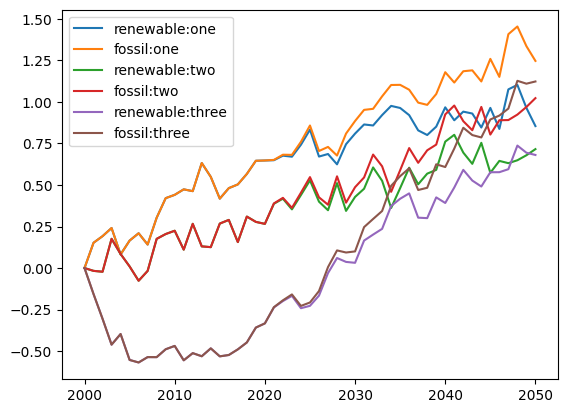

In [21]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.temperature.sel(layer=0, scenario=scenario, config=config), label=f"{scenario}:{config}");
pl.legend()

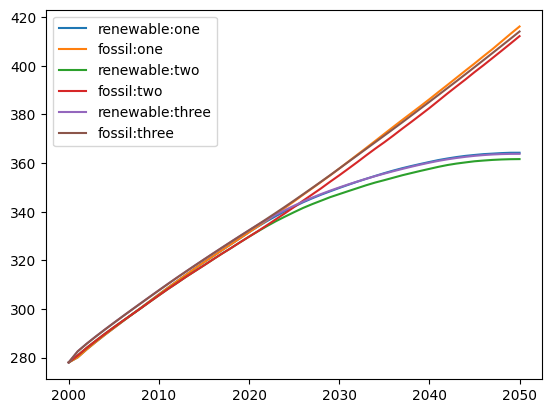

In [22]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.concentration.sel(scenario=scenario, config=config, specie="CO2"), label=f"{scenario}:{config}");
pl.legend()

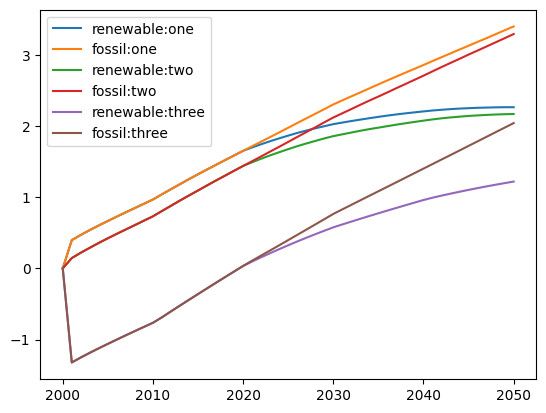

In [23]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.forcing_sum.sel(scenario=scenario, config=config), label=f"{scenario}:{config}");
pl.legend()